# Zillow Regression Project

### Project Overview

#### This project is designed to identify important features and build a regression model to predict tax-assessed property value for single home properties. This report uses 'cost' or 'value' to refer to a home's tax assessed value.

_______

### Goals

Create deliverables:
- READ ME
- Final Report
- Functional wrangle.py, explore.py, and model.py files
- Acquire Zillow data from the Codeup database using functions located in Wrangle file
- Prepare and split the data
- Explore the data and define hypotheses, running appropriate statistical tests to accept or reject each null hypothesis
- Create a baseline model in predicting home cost and document the Root Mean Square Error (RMSE)
- Fit and train four (4) regression models to predict cost on the train dataset
- Evaluate the models by comparing their performance on train and validation data
- Select the best model and evaluate it on testing data
- Develop and document findings, takeaways, recommendations and next steps

In [1]:
#Get Imports
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SK Learn
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

#Stats
from scipy.stats import pearsonr, spearmanr, kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

#My imports
import wrangle as w
import env
import model as m
import explore as e

_________

## Data Acquisition

- Data acquired from Codeup Database (11/14/2022)
- It contained 52,442 rows and 10 columns before cleaning
- Each row represents a single-family home located within Los Angeles, Orange, or Ventura County, California.
- Each column represents a feature of those homes

In [2]:
#Get the data
df = w.get_zillow_data()

### Data Dictionary

| Feature | Definition |
| --- | --- |
| Tax_Value | Value of a property computed by county utilizing tax data (TARGET VARIABLE)
| Bedrooms | Number of bedrooms listed for a property|
| Bathrooms | Number of bathrooms listed for a property |
| Square_Feet | Total square footage listed for a property |
| FIPS | Codes associated with US Counties |
| Latitude | Latitude associated to a property location |
| Longitude | Longitude associated to a property location |
| Lot_Size | Total area of a property lot |
| Year_Built | Year a property was constructed |
| Transaction_Date | Date a property was bought/sold |
| Parcel_ID | Unique identifying number associated with a property by Zillow |
| Home_Age | Feature-engineered column assigning an integer as "home age" by subtracting year built from 2017
| County| Feature-engineered column indicating the county a property is located in, utilizing FIPS code

## Preparing the Data

### Prepare Actions:

* Renamed columns to promote readability
* Checked for nulls and NaN values in the data, dropped Null Values stored as whitespace
* Checked that column data types were appropriate, converting data types to facilitate exploration and modeling
* Removed outliers utilizing the IQR method with a k value of 3
* Total data loss from removing outliers and null values was 4.8%

### Feature Engineering

* Mapped FIPS data to correspond to their appropriate county (LA, Orange, Ventura)
* Created a new column 'home_age' using year_built, casted as an integer

In [3]:
#Prepare the data for exploration using a function called from my 
#Get Clean data
df = w.clean_zillow(df)
df.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
0,4,3.5,3100.0,6059,33634931.0,-117869207.0,4506,1998,1023282,2017-01-01,14297519,Orange,19
1,2,1.0,1465.0,6111,34449266.0,-119281531.0,12647,1967,464000,2017-01-01,17052889,Ventura,50


### Data Splitting

* Split data into train, validate and test (approx. 75/12.5/12.5), stratifying on 'tax_value'

In [4]:
train, validate, test = w.train_validate_test_split(df)
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


## Summary of the data

In [5]:
##Visualization showing typical home of this data set

# Exploration

## Question 1: How does location impact home value?

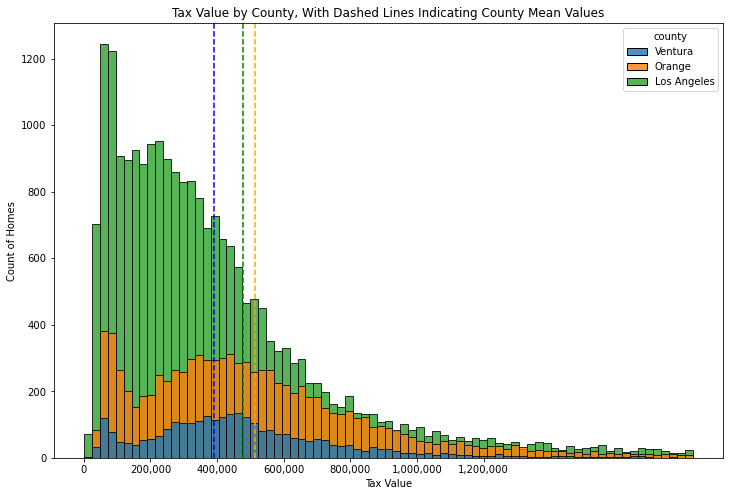

In [6]:
#Import visualization for home value
e.location_viz(train)

#### Homes in LA county are significantly less valuable than homes in Orange or Ventura counties. However, the variation of home values within LA couty are wide. LA county contains approximately 90 cities. Even with some outliers removed, the range of median home values within LA county in this data set is nearly 1.8 million. This is reflective of the diversity within LA County, which contains one of the nation's most expensive Zip Codes: Beverly Hills 90210, which in 2021 had a median home prices of 4.1 million (6th most expensive zip code in the nation). In comparison, one of the poorest cities in LA county, Compton, had a median home value of 355,200.

#### Taking this into consideration, I formulated a hypothesis that homes in LA county would be have a different value than homes located in Orange or Ventura county:

### Senior Citizen vs. Churn:

* I used a 95% confidence interval
* The resulting alpha value is .05

Hypotheses:

$H_0$: **Properties located in LA County and properties outside of LA County have the same tax value**

$H_a$: **Properties located in LA County and properties outside of LA County have different mean tax values.**

In [7]:
#Perform Kruskal-Wallis test
e.get_kruskal_county(train)

KruskalResult(statistic=1436.0241360646417, pvalue=0.0)

#### Since the P value is less than our alpha (0.05), we can reject the null hypothesis and say that there is a significant relationship between properties in LA County and properties in Ventura or Orange County, with respect to tax value.

# Question 2: Are bedrooms or bathrooms a better predictor of home value?

In [8]:
##Insert visualization here